## 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

### 4.1 Evaluation metrics: session overview

- Dataset:https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv('/home/timur/work_hub/ml_zoomcamp2023/3. Machine Learning for Classification/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
    
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)


df.churn = (df.churn == 'yes').astype(int)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values


del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
               'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
               'paymentmethod']

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [12]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)


y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

### 4.2 Accuracy and dummy model

- Evaluate the model on different thersholds
- Check the accuracy of dummy baselines

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [24]:
scores

[0.2739531582682754,
 0.5088715400993612,
 0.5911994322214337,
 0.6664300922640171,
 0.7097232079489,
 0.7388218594748048,
 0.7601135557132718,
 0.7721788502484032,
 0.7849538679914834,
 0.7934705464868701,
 0.8034066713981547,
 0.801277501774308,
 0.794889992902768,
 0.7863733144073811,
 0.765791341376863,
 0.7444996451383961,
 0.7345635202271115,
 0.7260468417317246,
 0.7260468417317246,
 0.7260468417317246,
 0.7260468417317246]

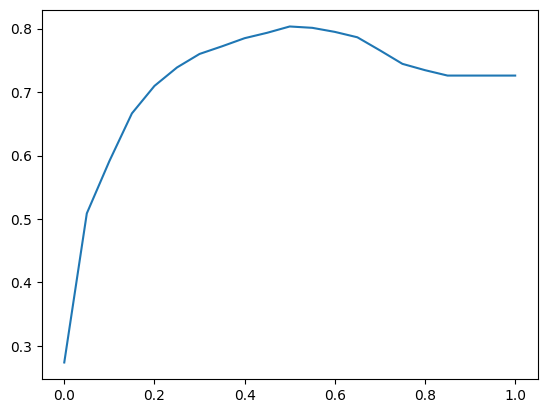

In [25]:
plt.plot(thresholds, scores)

So we checked different churn decision score and indeed score >0.5 gave us the best result

But we also have a problem here. Let's look on our the first and the last decision score 

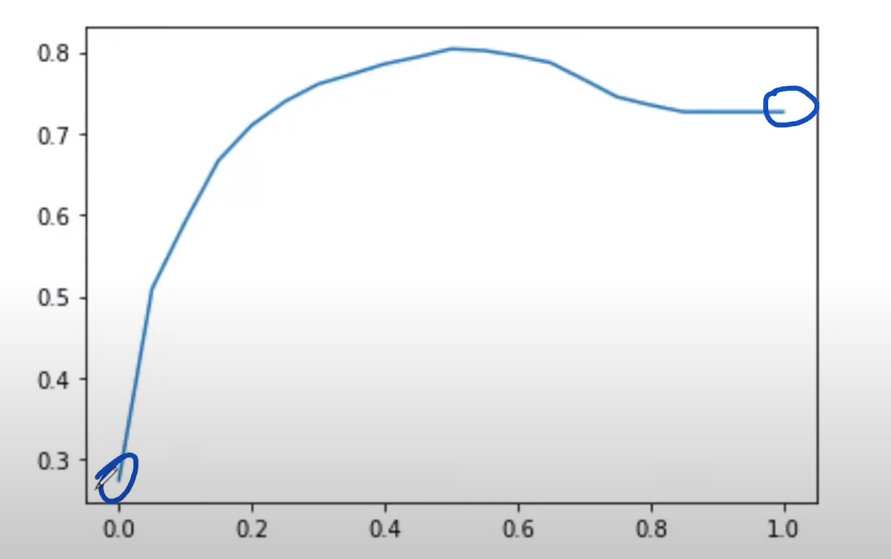

If we take churn decision score = 1.0 it means in our model that we say what our cusomers are churning if the score will be > 1. It's technically means what all customers aren't churning because we don't have values > 1

In [31]:
from collections import Counter

In [32]:
Counter(y_pred >= 1)

Counter({False: 1409})

#### In other words our model 'tells' us (wrongly): 'Ok, relax, there aren't any problems, nobody going to churn'

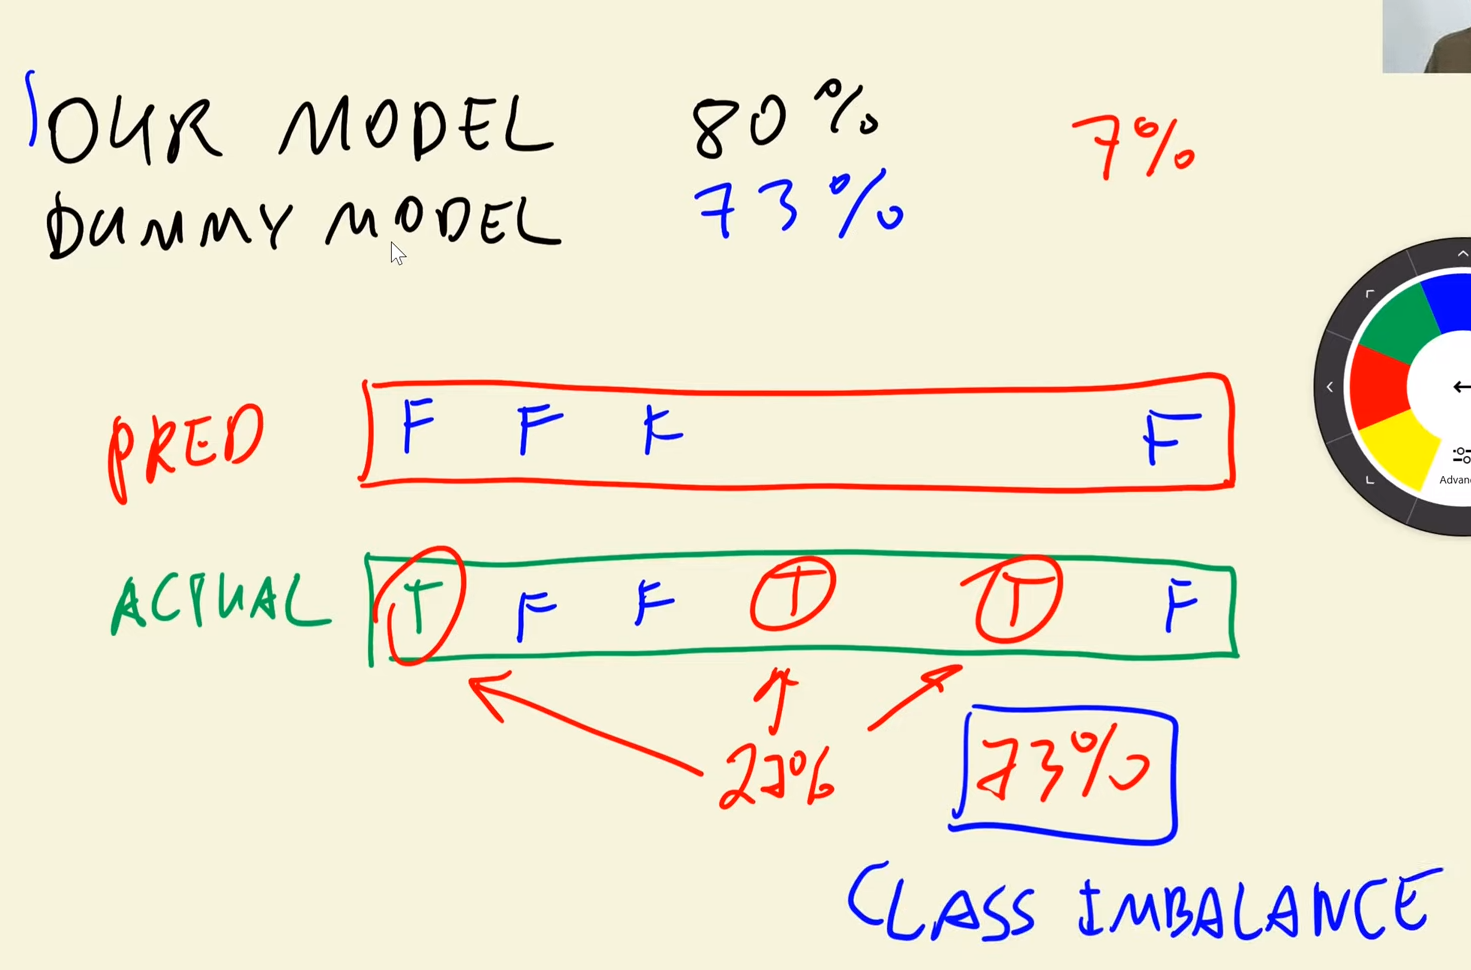

That's the problem with accuracy when we have class imbalance (how in our case). We see that only 27% of our users are going to churnig 

In [33]:
y_val.mean()

0.2739531582682754

### 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in table

In [40]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [41]:
actual_positive

array([False, False, False, ..., False,  True,  True])

In [42]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [43]:
predict_positive

array([False, False, False, ..., False,  True,  True])

In [45]:
tp = (predict_positive & actual_positive).sum()
tp

210

In [46]:
tn = (predict_negative & actual_negative).sum()
tn

922

In [47]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [48]:
fp, fn

(101, 176)

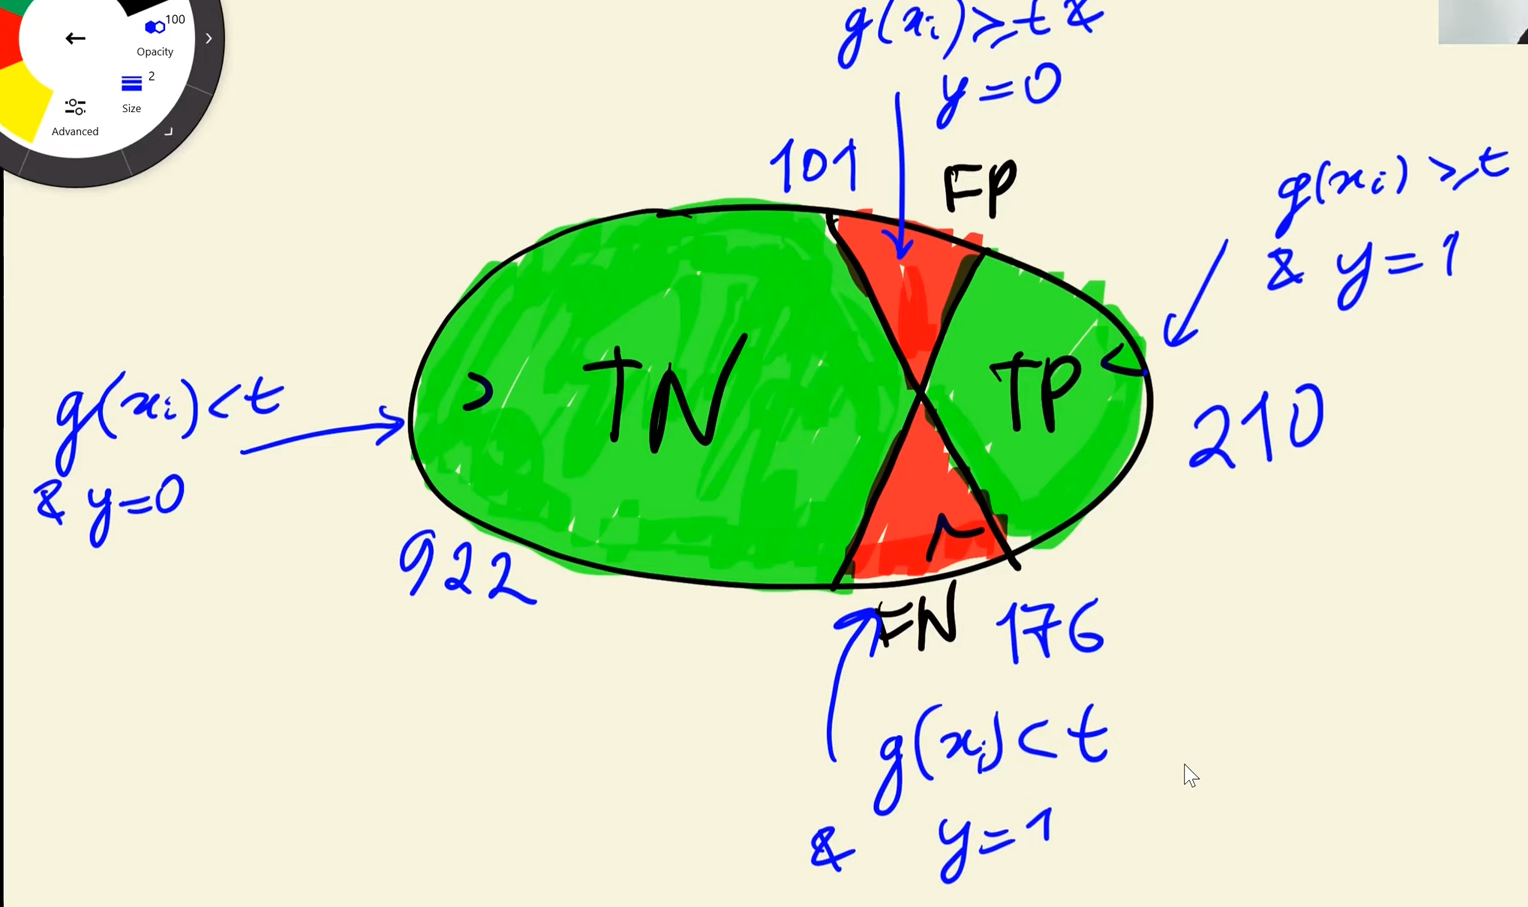

Confusion table 

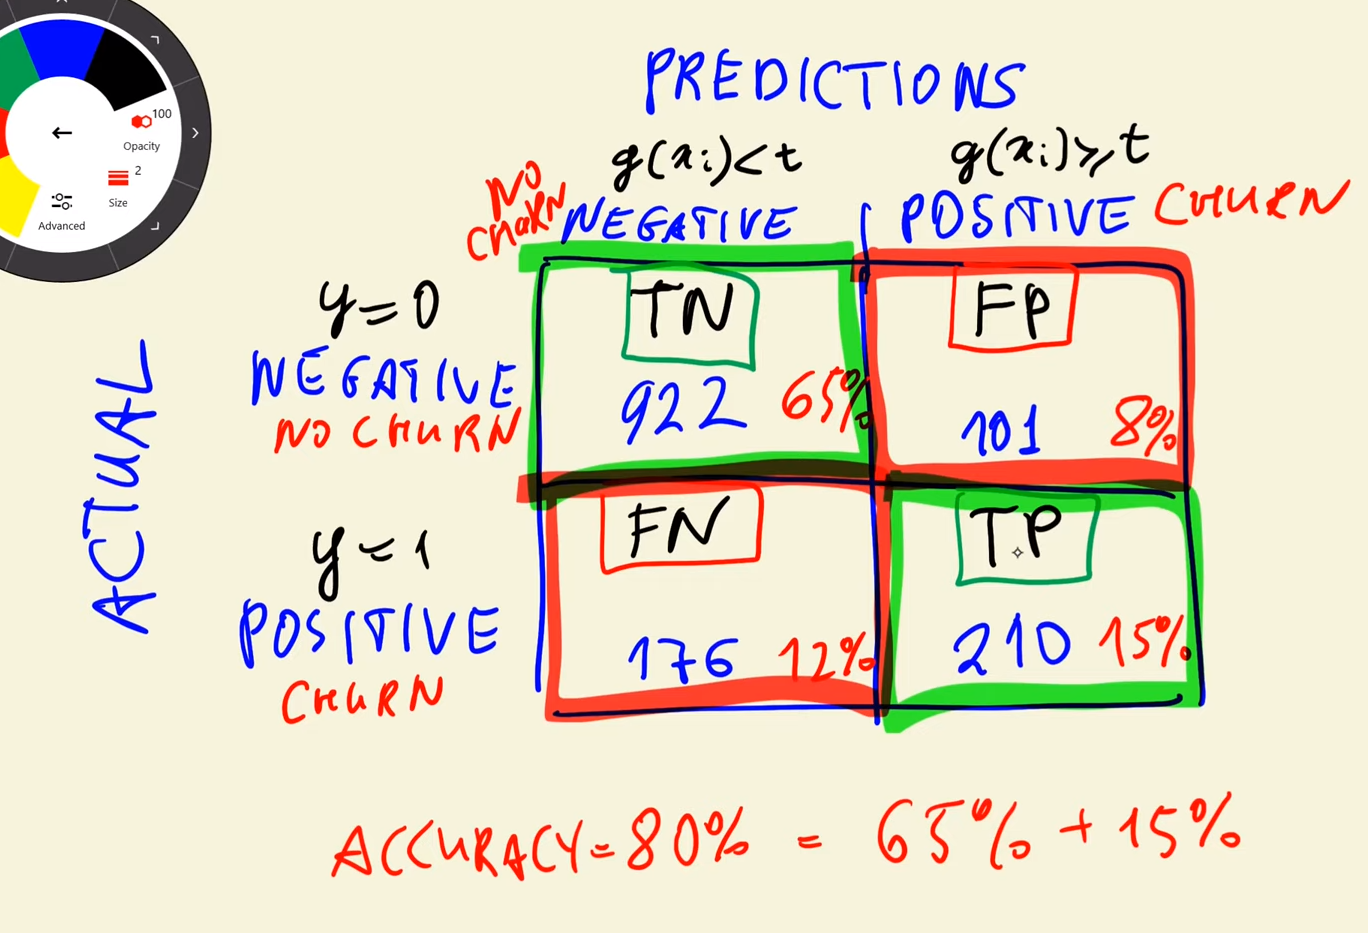

Let's implement it in NumPy

In [50]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [51]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

Our accuracy

In [52]:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

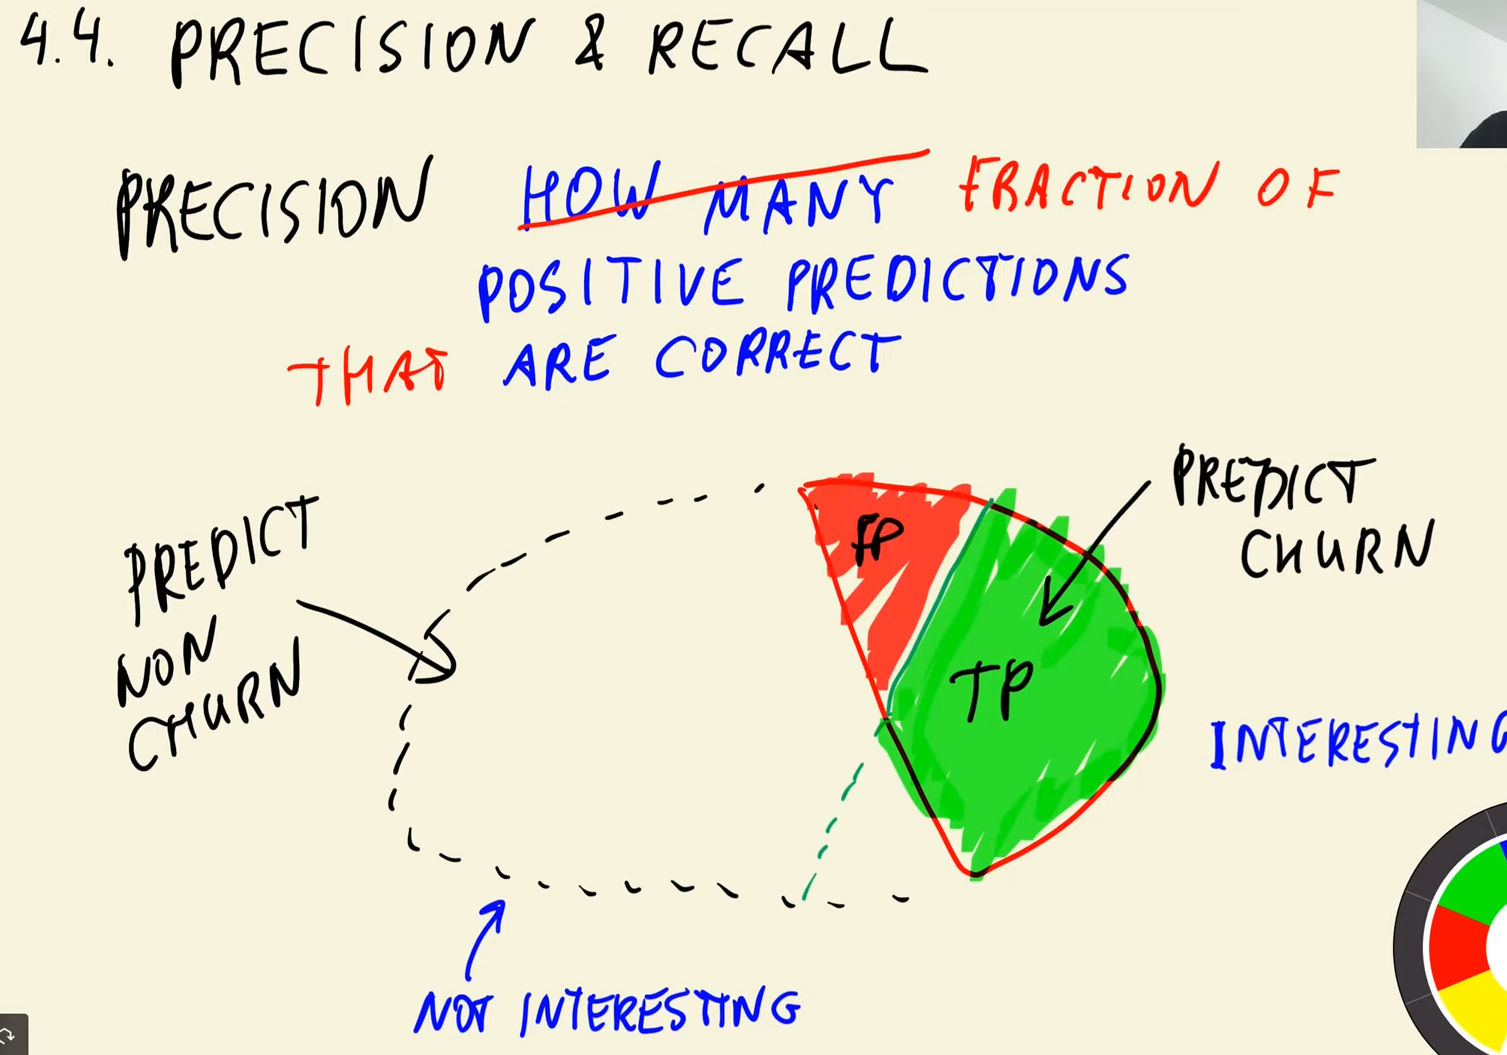

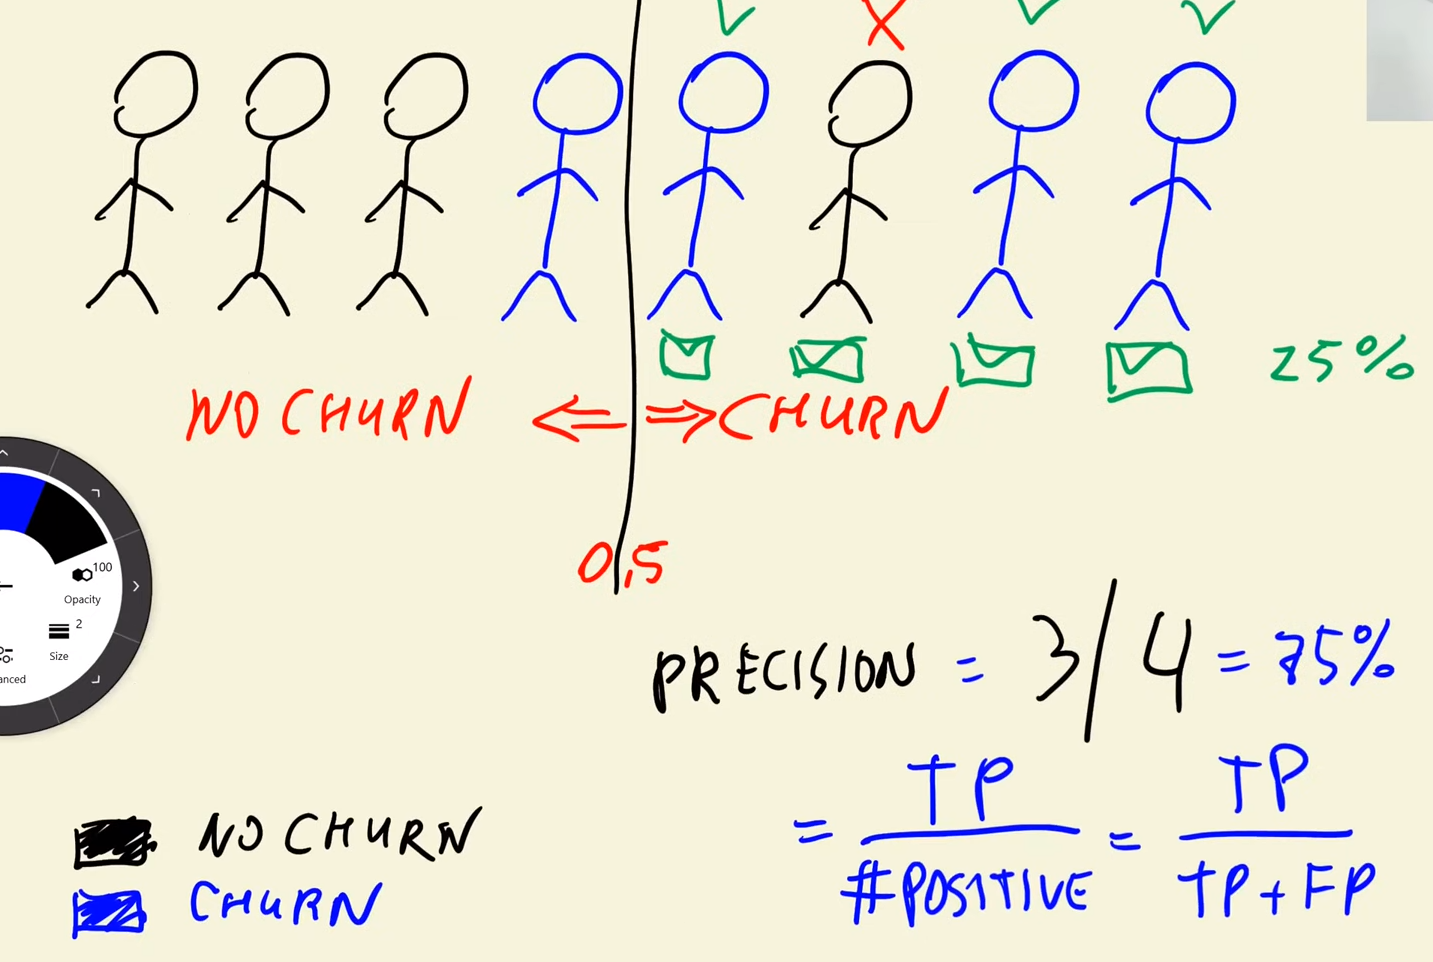

Let's implement this

In [54]:
precision = tp / (tp + fp)
precision

0.6752411575562701

In [55]:
tp

210

In [56]:
tp + fp

311

So **precision** can tell us that we think that 311 customers are going to churn and have to sent them promotion in order to hold them with our company. But in reallity only 210 customers (or 67%) of our prediction will actually churn.

Recall

 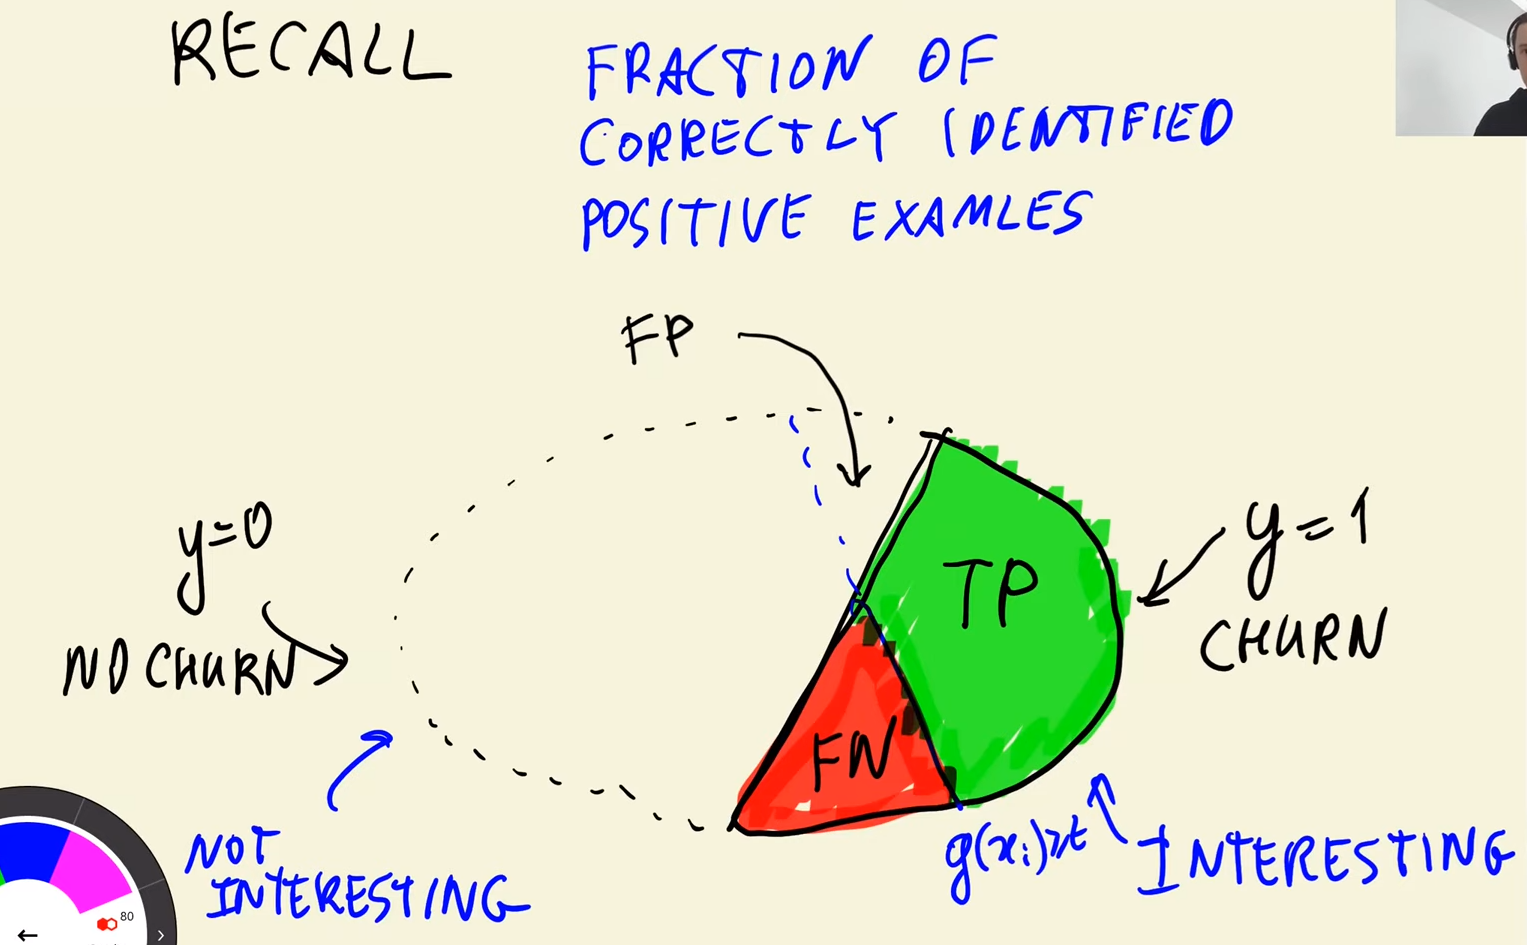

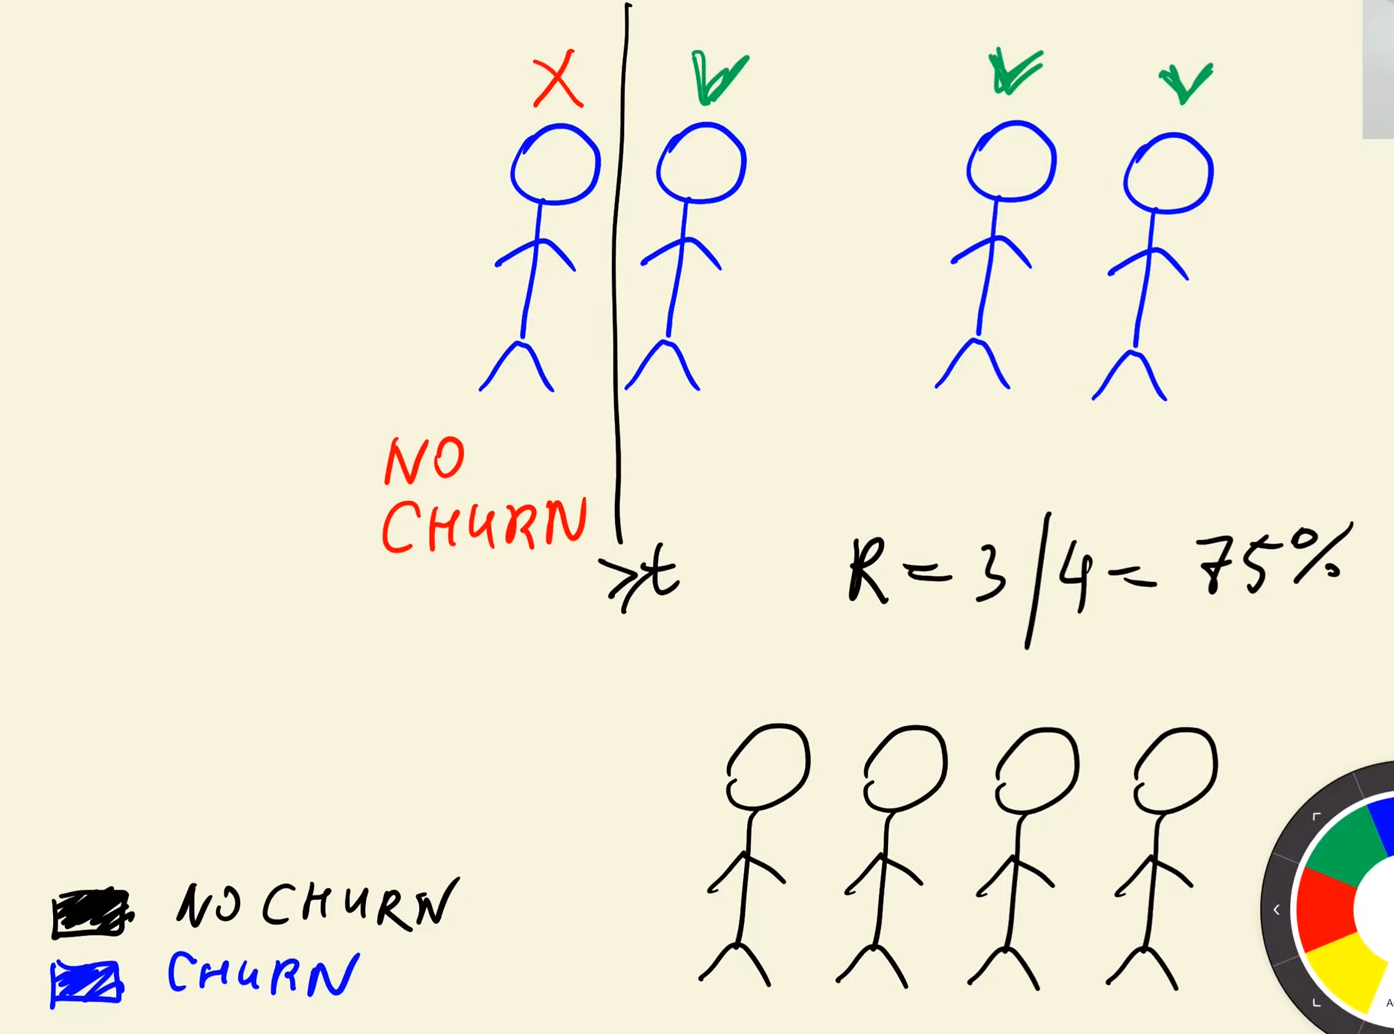

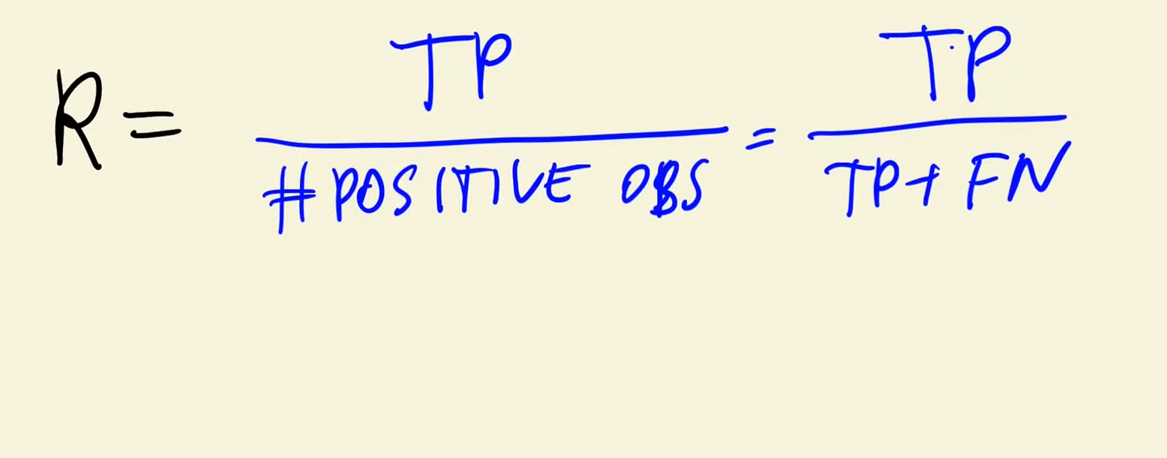

Let's implement this

In [58]:
recall = tp / (tp + fn)
recall

0.5440414507772021

So recall shows us that we failed to identify 46% of our potential churn client

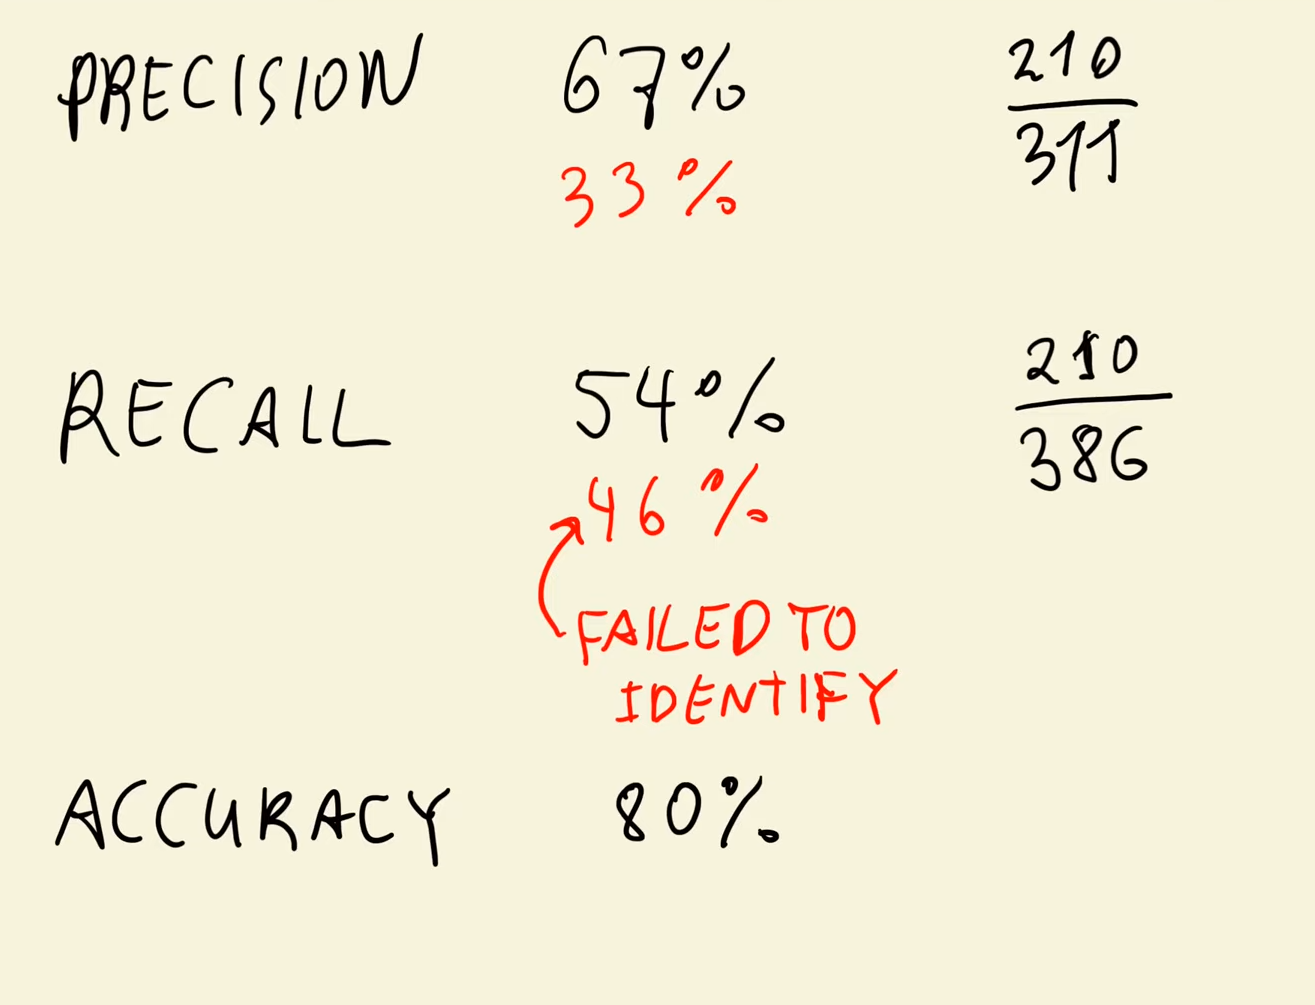

What picture above shows exactly. At first we get our accuracy score and thought that our model pretty correct, because 80% accuracy looks like a good quality, right? 

Actually not. If we look at **precision and recall metrics** we see that 33% of our promotion which were send to our potential churn customers wasn't necessary (**precision**) and 46% of potential churn customets we didn't identify (**recall**). From that point of your quality of our model doesn't look good.


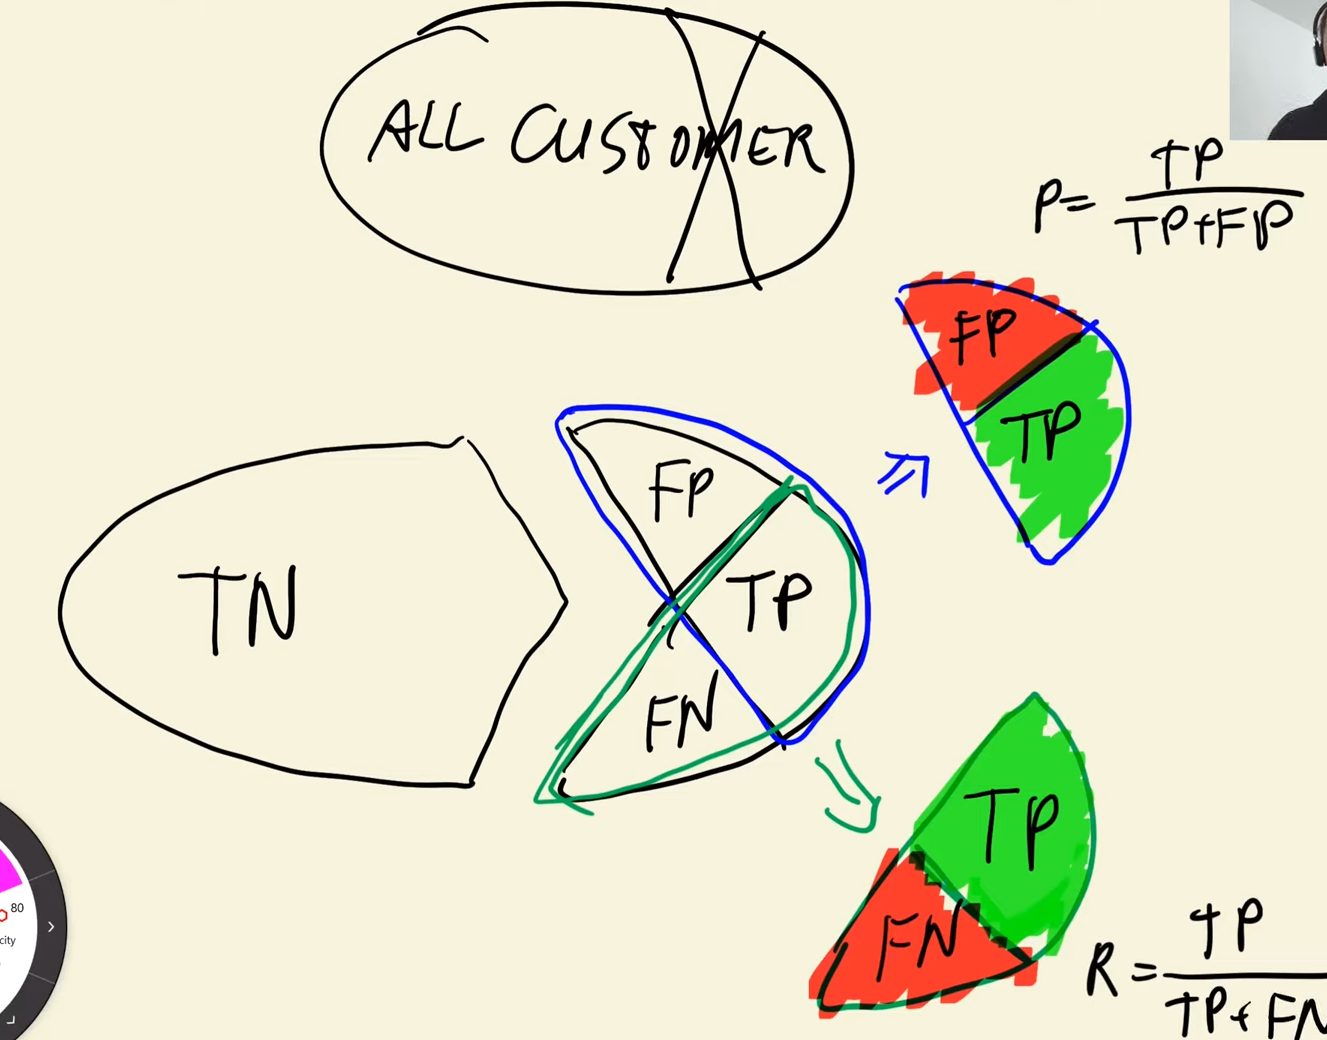

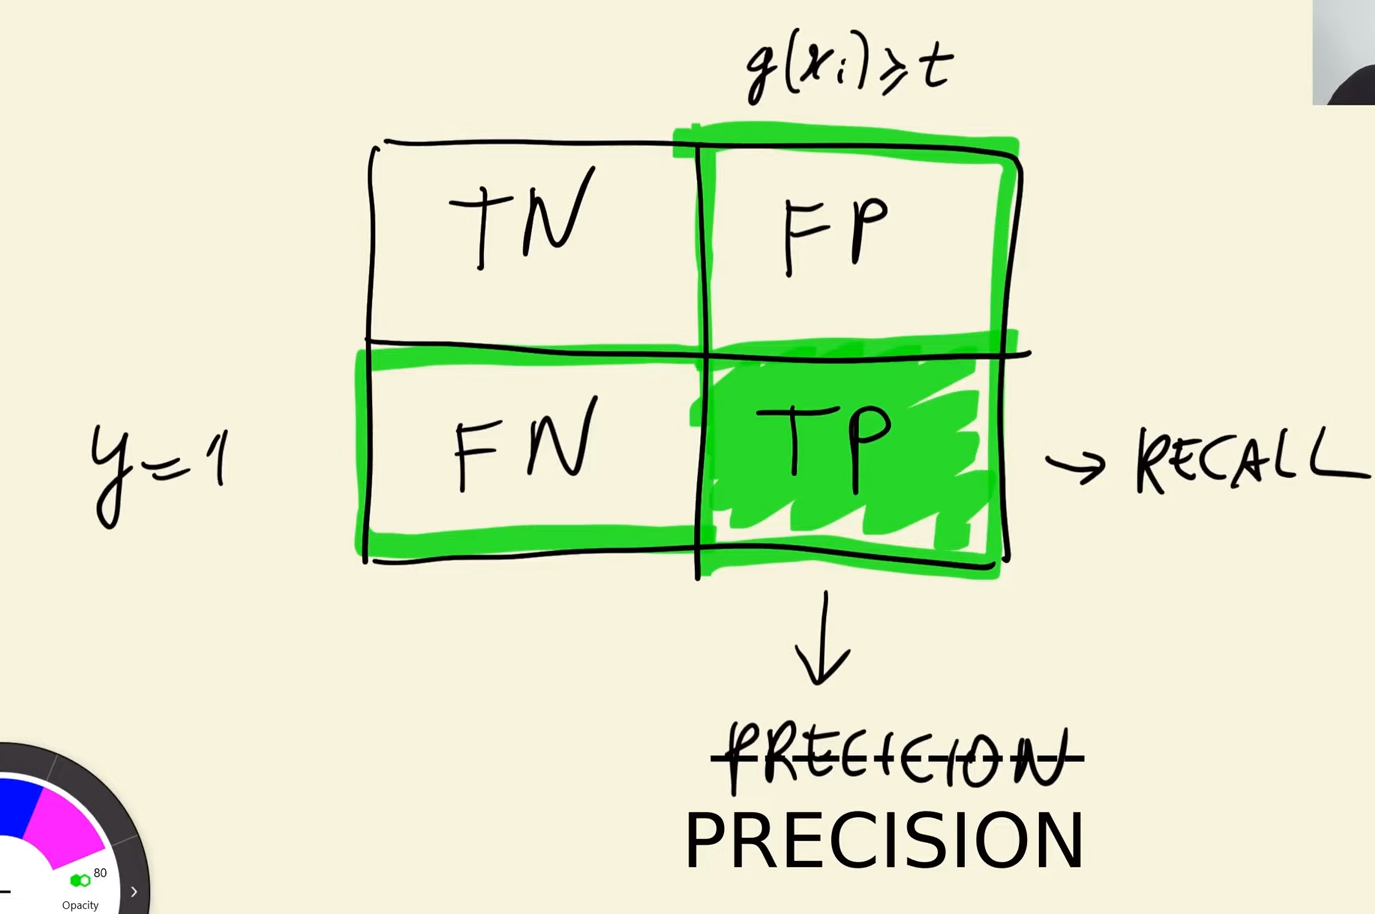